In [1]:
import os
import pathlib

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

DIR_HOME = pathlib.Path("..").absolute()
DIR_EVAL = DIR_HOME / "data" / "evaluations"

In [2]:
DIR_EVAL / "eval_results.csv"

PosixPath('/home/dogdog/Projects/distill-retriever/notebooks/../data/evaluations/eval_results.csv')

In [3]:
df = pd.read_csv(DIR_EVAL / "eval_results.csv")
df_no_distill = df.loc[df.query_encoder.isna()]

<Axes: xlabel='Dataset Name', ylabel='NDCG@10'>

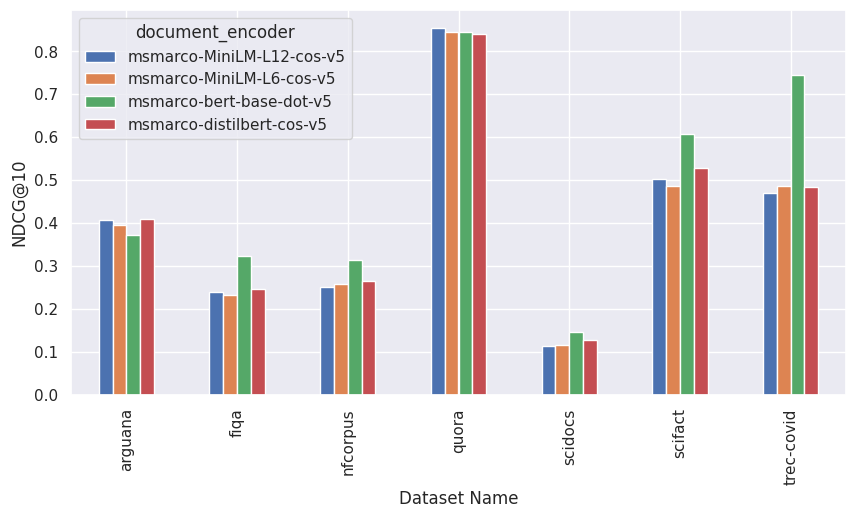

In [4]:
df_no_distill.pivot(index="dataset_name",
                    columns="document_encoder",
                    values="NDCG@10") \
             .plot.bar(figsize=(10, 5),
                       ylabel="NDCG@10",
                       xlabel="Dataset Name")

<Axes: xlabel='Dataset Name', ylabel='NDCG@10'>

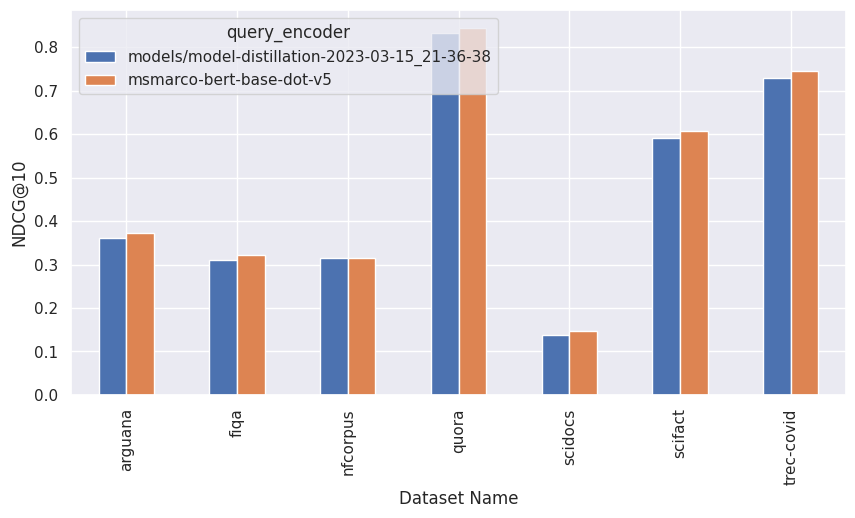

In [6]:
df_distill = df.loc[df.document_encoder == "msmarco-bert-base-dot-v5"]
df_distill.loc[df_distill.query_encoder.isna(), "query_encoder"] = "msmarco-bert-base-dot-v5"
df_distill.pivot(index="dataset_name",
                 columns="query_encoder",
                 values="NDCG@10") \
          .plot.bar(figsize=(10, 5),
                    xlabel="Dataset Name",
                    ylabel="NDCG@10")